<h1><b>Image Captioning from Flickr8k

<h2><b>Downloading Flickr8k Dataset

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [2]:
%%time
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:06<00:00, 278MB/s]
100% 1.04G/1.04G [00:06<00:00, 166MB/s]
CPU times: user 94.1 ms, sys: 9.66 ms, total: 104 ms
Wall time: 7.35 s


In [ ]:
!unzip "/content/flickr8k.zip" -d "/content/Image caption data"

<h1><b>Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import re
from tqdm.notebook import tqdm
from pprint import pprint
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model
from keras.models import Model

<h2><b>Image Feature Extraction

Using <b>VGG16</b> model to extract feature from image.

In [16]:
model_img = VGG16()
model_img = Model(inputs = model_img.inputs, outputs=model_img.layers[-2].output)
model_img.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [11]:
model_img.save('/content/Flickr8k_VGG16.h5')

In [ ]:
len(os.listdir('/content/Image caption data/Images'))

8091

In [ ]:
features = {}
for img in tqdm(os.listdir('/content/Image caption data/Images')):
    img_path = '/content/Image caption data/Images/'+img
    image = load_img(img_path, target_size = (224, 224))
    image_arr = img_to_array(image)
    image_arr = image_arr.reshape((1, image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]))
    image_arr = preprocess_input(image_arr)
    feature = model_img.predict(image_arr, verbose = 0)

    img_name = img.split('.')[0]
    features[img_name] = feature

In [ ]:
pickle.dump(features, open('features.pkl', 'wb'))

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Projects/Intern/Image Captioning/pkl files/img_features.pkl', 'rb') as f:
    features = pickle.load(f)

<h2><b>Reading Dataset

In [ ]:
caption_path = '/content/Image caption data/captions.txt'
with open(caption_path, 'r') as f:
    next(f)
    caption_file = f.read()

<h2><b>Data Preprocessing

In [ ]:
mapping = {}
for line in caption_file.split('\n'):
    if line == '':
        continue
    img_name = line.split(',')[0].split('.')[0]
    caption = line.split(',')[1:]
    caption = " ".join(caption)
    if img_name not in mapping:
        mapping[img_name] = []
    mapping[img_name].append(caption)

In [ ]:
len(mapping)

8091

<h3><b>Caption Preprocessing

<h4><b>Steps</b></h4>
<ul>
<li> Convert sentences into lowercase
<li> Remove special characters and numbers present in the text
<li> Remove extra spaces
<li> Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence
<ul>

In [ ]:
def caption_preprocessing(mapping):
    for img_name, caption_list in mapping.items():
        for i in range(len(caption_list)):
            caption = caption_list[i]
            caption = caption.lower()
            caption = re.sub('[^A-Za-z ]', '', caption)
            # caption = caption.replace('[^A-Za-z]', '')
            caption = re.sub(' +', ' ', caption)
            caption = 'startseq ' + caption + ' endseq'
            # caption_list[i] = caption
            caption_list[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
caption_preprocessing(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq',
 'startseq a girl going into a wooden building  endseq',
 'startseq a little girl climbing into a wooden playhouse  endseq',
 'startseq a little girl climbing the stairs to her playhouse  endseq',
 'startseq a little girl in a pink dress going into a wooden cabin  endseq']

In [ ]:
all_caption = []
for img_name, captions in mapping.items():
    for caption in captions:
        all_caption.append(caption)

In [ ]:
len(all_caption)

40455

In [ ]:
all_caption[108:115]

['startseq a person in blue and red ice climbing with two picks  endseq',
 'startseq climber climbing an ice wall endseq',
 'startseq a black dog carries a green toy in his mouth as he walks through the grass  endseq',
 'startseq a black dog carrying something through the grass  endseq',
 'startseq a black dog has a blue toy in its mouth  endseq',
 'startseq a dog in grass with a blue item in his mouth  endseq',
 'startseq a wet black dog is carrying a green toy through the grass  endseq']

<h3><b>Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
pickle.dump(tokenizer, open('Flickr8k_tokenizer.pkl', 'wb'))

In [ ]:
vocab_size

8781

In [ ]:
max_length = max(len(caption.split()) for caption in all_caption)
max_length

37

<h2><b>Train Test Split

In [ ]:
image_name = list(mapping.keys())
split = int(len(image_name)*0.9)
train = image_name[:split]
test = image_name[split:]

<h3>Data Generator for Batch Training

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = [], [], []
                n = 0

In [ ]:
caption = "hey startseq this boy toy bat cricket"
aa = tokenizer.texts_to_sequences([caption])[0]
print(aa)
in_seq, out_seq = aa[:], aa[2]
print(to_categorical([out_seq], num_classes=17)[0])
# print(in_seq, out_seq)

[2, 329, 16, 104, 453, 765]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


<h2><b>Model building

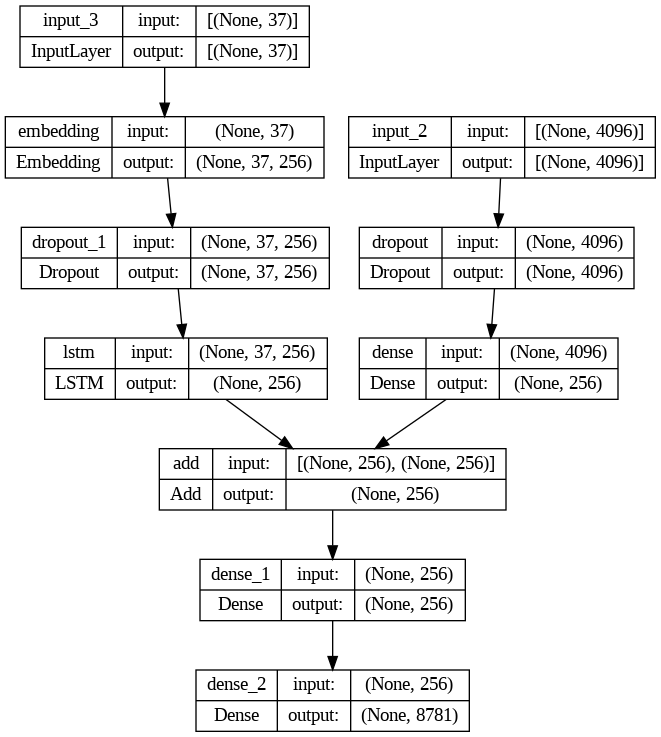

In [ ]:
# Image Feature
inputs1 = Input(shape=(4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# seq feature layer
inputs2 = Input(shape=(max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


plot_model(model, show_shapes=True)

<h2><b>Model Training

In [ ]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save('/content/best_model.h5')

227/227 [==============================] - 74s 324ms/step - loss: 1.9289


In [ ]:
pickle.dump(model, open('/content/model.pkl', 'wb'))

<h2><b>Generating Caption

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Projects/Intern/Image Captioning/h5/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

<h2><b>Score

In [ ]:
actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.587657
BLEU-2: 0.395966


In [ ]:
# generating image from train dataset
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("/content/Image caption data/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq a black and white dog jumping in the air to get a toy  endseq
startseq a black and white dog jumps up towards a yellow toy  endseq
startseq a dog leaps to catch a ball in a field  endseq
startseq a white dog is trying to catch a ball in midair over a grassy field  endseq
startseq the white dog is playing in a green field with a yellow toy  endseq
--------------------Predicted--------------------
startseq a dog is running through a field of yellow flowers endseq


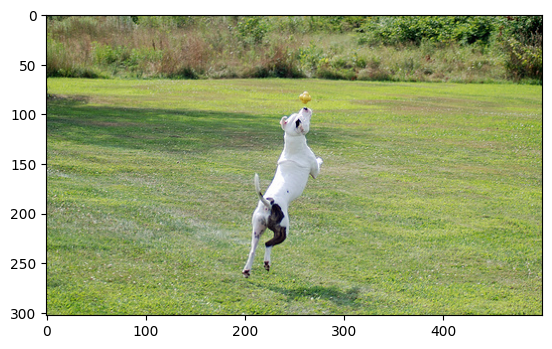

In [ ]:
generate_caption('1020651753_06077ec457.jpg')

In [ ]:
# generating image for new image
def generate_caption_with_image_path(image_path):
    image = load_img(image_path, target_size = (224, 224))
    print("Image found...")
    image_arr = img_to_array(image)
    print("Processing Image...")
    image_arr = image_arr.reshape((1, image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]))
    image_arr = preprocess_input(image_arr)
    feature = model_img.predict(image_arr, verbose = 0)
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    plt.imshow(image)
    print("In this Image...")
    y_pred = y_pred.replace('startseq ', '')
    y_pred = y_pred.replace(' endseq', '')
    print(y_pred)

Image found...
Processing Image...
In this Image...
a man in a green dress is standing on a stool with a red umbrella


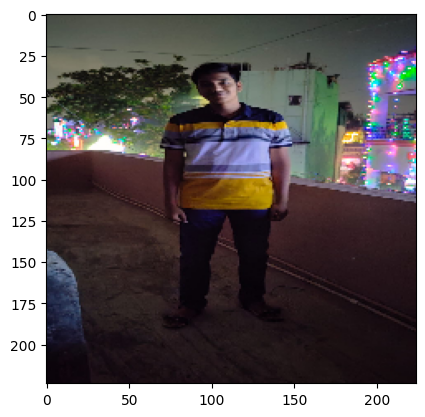

In [ ]:
generate_caption_with_image_path('/content/happiness-in-daily-life.jpg')